In [1]:
# Importing all required libraries
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import os
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import QuantileDiscretizer
import pandas as pd
import numpy as np
from math import isnan
import pyspark.sql.functions as f

In [2]:
import matplotlib as mpl

In [3]:
# Building Spark session necessary to do before starting any spark code
spark = SparkSession.builder.appName("CG_analysis").getOrCreate()

In [4]:
# Spark datatypes to contruct schema
from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                               TimestampType)

In [5]:
data_schema=StructType([StructField("PassengerId", IntegerType(), True),
                            StructField("Survived", IntegerType(), True),
                            StructField("Pclass", IntegerType(), True ),
                            StructField("Name", StringType(), True),
                            StructField("Sex", StringType(), True),
                            StructField("Age", DoubleType(), True),
                            StructField("SibSp", IntegerType(), True),
                            StructField("Parch", IntegerType(), True),
                            StructField("Ticket", StringType(), True),
                            StructField("Fare", DoubleType(), True),
                            StructField("Cabin", StringType(), True),
                            StructField("Embarked", StringType(), True)
                            ])

In [6]:
data = spark.read.csv("titanic.csv",
                       header = True, 
                        schema = data_schema)

In [7]:
data.head(5)

[Row(PassengerId=1, Survived=0, Pclass=3, Name='Braund, Mr. Owen Harris', Sex='male', Age=22.0, SibSp=1, Parch=0, Ticket='A/5 21171', Fare=7.25, Cabin=None, Embarked='S'),
 Row(PassengerId=2, Survived=1, Pclass=1, Name='Cumings, Mrs. John Bradley (Florence Briggs Thayer)', Sex='female', Age=38.0, SibSp=1, Parch=0, Ticket='PC 17599', Fare=71.2833, Cabin='C85', Embarked='C'),
 Row(PassengerId=3, Survived=1, Pclass=3, Name='Heikkinen, Miss. Laina', Sex='female', Age=26.0, SibSp=0, Parch=0, Ticket='STON/O2. 3101282', Fare=7.925, Cabin=None, Embarked='S'),
 Row(PassengerId=4, Survived=1, Pclass=1, Name='Futrelle, Mrs. Jacques Heath (Lily May Peel)', Sex='female', Age=35.0, SibSp=1, Parch=0, Ticket='113803', Fare=53.1, Cabin='C123', Embarked='S'),
 Row(PassengerId=5, Survived=0, Pclass=3, Name='Allen, Mr. William Henry', Sex='male', Age=35.0, SibSp=0, Parch=0, Ticket='373450', Fare=8.05, Cabin=None, Embarked='S')]

In [9]:
eda_op_dict={}

In [8]:
def outlier_treatment_process(df,c):
    q1,q3 = df.approxQuantile(c, [0.25, 0.75], 0)
    iqr = q3 - q1
    #print(q1,q3)
    minimum = q1 - (iqr * 1.5)
    maximum = q3 + (iqr * 1.5)
    return minimum

In [10]:
def discrete_count_plot(result,column):
    mpl.style.use('seaborn')
    plt.bar(range(len(result)), list(result.loc[:,'count'].values), align='center')
    plt.xlabel(column,fontsize=15)
    plt.ylabel('Counts',fontsize=15)
    plt.xticks(range(len(result)), list(result.loc[:,column].values),fontsize=15,rotation=65, horizontalalignment='right')
    plt.title('Count Histogram Representation for '+column,fontsize=15)
    plt.savefig(column+'.png',bbox_inches = "tight")
    

In [12]:
def continuous_count_plot(result,column,labels=None):
    mpl.style.use('seaborn')
    if labels is None:
        labels=list(result.loc[:,'labels'].values)
        
    #plt.figure(figsize=(16,300))
    plt.bar(range(len(result)), list(result.loc[:,'count'].values), align='center')
    plt.xlabel(column,fontsize=15)
    plt.ylabel('Counts',fontsize=15)
    plt.xticks(range(len(result)), labels,fontsize=15,rotation=65, horizontalalignment='right')
    plt.title('Count Histogram Representation for '+column,fontsize=15)
    plt.savefig(column+'.png',bbox_inches = "tight")

In [13]:
from pyspark.sql.functions import col
def get_continuous_lab(unlabel_list,inputCol,outputCol,query_frame,get_scientfic=False):
    label_df=pd.DataFrame()
    label_list=[]
    for i in unlabel_list:
        re=query_frame.filter(col(outputCol).isin([i]))
        mini=re.agg({inputCol: "min"}).collect()[0]['min('+inputCol+')']
        if get_scientfic:
            if mini is not None:
                mini='%e' % mini
        maxm=re.agg({inputCol: "max"}).collect()[0]['max('+inputCol+')']
        if get_scientfic:
            if maxm is not None:
                maxm='%e' % maxm
        label_list.append(str(mini)+'-'+str(maxm))
    label_df[outputCol]=unlabel_list
    label_df['labels']=label_list
    return label_df

In [27]:
def discrete_univariate_analysis(data,column,max_cat_len=5,save_csv=False):
        df=data.groupBy(column).count().toPandas()
        #sorting in descending
        df=df.sort_values(by='count',ascending=False)
        if len(df)>max_cat_len:
            #taking required max length 
            df_max_cat_len=df[:max_cat_len]
            #making dict out of df
            dict_df_max=dict(zip(df.loc[:,column], df.loc[:,'count']))
            #converting the keys to str
            dict_df_max_string = dict([(str(k), v) for k, v in dict_df_max.items()])
            #saving values of nan 
            if ('nan' in dict_df_max_string):
                df_nan=pd.DataFrame({column:'nan','count':dict_df_max_string['nan']},index=[1])
            else:
                df_nan=pd.DataFrame()
            #taking sum of other values and putting in other category
            sum_other_category_val=pd.DataFrame({column:'others','count':sum(df.loc[max_cat_len:,'count'])},index=[1])
            #concatenating all of them
            df_shorted_max = pd.concat([df_max_cat_len,df_nan,sum_other_category_val])
            #plotting dataframe
            discrete_count_plot(df_shorted_max,column)
            if save_csv:
                df_shorted_max.to_csv(column+'.csv',index=False)
            # Update the dictionary
            #eda_op_dict.update({'chart_id'+str(len(eda_op_dict)):{'column_name':column,'img_path':os.getcwd()+'/'+column+'.png','count':df}})
        else:
            #plotting dataframe
            discrete_count_plot(df,column)
        # Update the dictionary
            if save_csv:
                df.to_csv(column+'.csv',index=False)
        eda_op_dict.update({'chart_id'+str(len(eda_op_dict)):{'column_name':column,'img_path':os.getcwd()+'/'+column+'.png','count':df}})


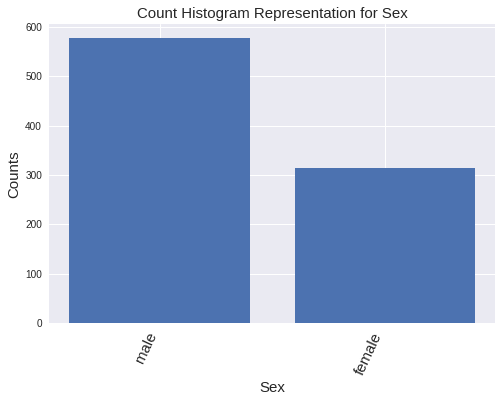

In [23]:
discrete_univariate_analysis(data,"Sex",save_csv=True)

In [22]:
eda_op_dict

{'chart_id0': {'column_name': 'Sex',
  'img_path': '/home/nbuser/library/Sex.png',
  'count':       Sex  count
  1    male    577
  0  female    314},
 'chart_id1': {'column_name': 'Cabin',
  'img_path': '/home/nbuser/library/Cabin.png',
  'count':                Cabin  count
  45              None    687
  31           B96 B98      4
  73                G6      4
  99       C23 C25 C27      4
  15                F2      3
  25           C22 C26      3
  71              E101      3
  103              F33      3
  67                 D      3
  34               D20      2
  125               C2      2
  69              C124      2
  37                E8      2
  104               B5      2
  90               D17      2
  128  B57 B59 B63 B66      2
  121             C125      2
  120              D26      2
  105              E24      2
  65               C93      2
  63               C68      2
  48              C123      2
  50               C83      2
  60              E121      2
  5

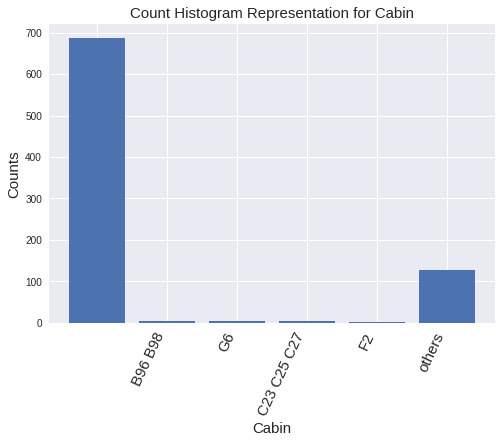

In [20]:
discrete_univariate_analysis(data,"Cabin")

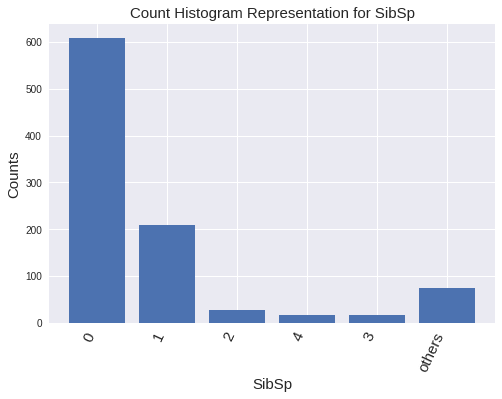

In [21]:
discrete_univariate_analysis(data,"SibSp")

In [26]:
def continuous_univariate_analysis(data,column,outlier_treat=False,Buckets=5,outlier_treatment=False,save_csv=False,get_scientfic_val=False):
    out_col="bucket_labels"# just given a hardcoded naming to output of label column,this does not affect code 
    # here I am selecting the column 
    data_col=data.select(column)
    # Treating the outlier in left of ditribution anything less than q1 - (iqr * 1.5) is removed  .
    if outlier_treatment:
        minimum=outlier_treatment_process(data,column)
        data_col=data_col.filter(column+'>'+str(minimum))
        
     
    #QuantileDiscretizer is used when no labels are passed and only number of buckets needed are given 
    # or by default 5 is what I have taken for this function , here separate column for nan will be formed 
    # as I have used handleInvalid parameter, this gives us labels for each values in column
    discretizer = QuantileDiscretizer(numBuckets=Buckets, inputCol=column, outputCol=out_col,handleInvalid="error")
    result_buckets = discretizer.setHandleInvalid("keep").fit(data_col).transform(data_col)
    # we get the labels from QuantileDiscretizer and grouby by the labels to get count for each labels
    label_count_df=result_buckets.groupBy(out_col).count().toPandas().sort_values(by=out_col,ascending=True)
    # now we need to know which labels represents which range so we find out firstly distinct labels
    labels_distinct=list(label_count_df[out_col])
    # now get_continuous_lab helps us to get the min and max values of particular label and gives list of 
    #labels as output
    output_labels=get_continuous_lab(labels_distinct,column,out_col,result_buckets,get_scientfic=get_scientfic_val)
    merged_df_labels=pd.merge(output_labels,label_count_df,on=out_col,how="inner")
    #print(merged_df_labels)
    continuous_count_plot(merged_df_labels,column)# plotting the dataframe
    # Update the dictionary
    if save_csv:
        merged_df_labels.to_csv(column+'.csv',index=False)
    
    eda_op_dict.update({'chart_id'+str(len(eda_op_dict))+'_continuous_data':\
    {'column_name':column,'img_path':os.getcwd()+'/'+column+'.png'},'count_frame':label_count_df})

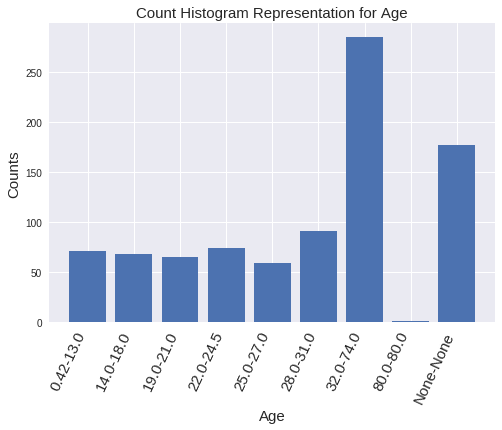

In [29]:
continuous_univariate_analysis(data,"Age",Buckets=10,outlier_treatment=False,save_csv=True,get_scientfic_val=False)

In [ ]:
continuous_univariate_analysis(data,"Fare",Buckets=3)

In [ ]:
continuous_univariate_analysis(data,"Fare",Buckets=5,outlier_treatment=True,save_csv=True,get_scientfic_val=True)